In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from nzdownscale.downscaler.validate_ERA import ValidateERA
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

/home/emily/mambaforge/envs/deepsensor/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# model_name = 'hourly_1e-5_v2'
model_name = 'era_test_small'
var = 'temperature'

# model_name = 'precip_nesi_intervals5'
# var = 'precipitation'

top_dir = '/mnt/temp/projects/DeepWeather/data_delete/DeepSensor/models'

model_dir = f'{top_dir}/{var}/{model_name}'
model_path = f'{model_dir}/{model_name}.pt'
train_metadata_path = f'{model_dir}/metadata_{model_name}.pkl'

# model_dir2 = f'/home/emily/deepsensor/deepweather-downscaling/experiments/'\
#             f'models/{var}/hourly_v2'
data_processor_path = f'{model_dir}/data_processor.pkl'
task_loader_path = f'{model_dir}/task_loader.pkl'

In [4]:
validate = ValidateERA(model_path,
                      data_processor_path,
                      task_loader_path,
                      train_metadata_path)

Producing predictions at resolution: 0.01


In [5]:
print(validate.data_processor)

DataProcessor with normalisation params:
{'TPI_0.025': {'method': 'min_max',
               'params': {'max': 157.2187957763672,
                          'min': -111.61631774902344}},
 'TPI_0.05': {'method': 'min_max',
              'params': {'max': 391.0797119140625, 'min': -265.4579772949219}},
 'TPI_0.1': {'method': 'min_max',
             'params': {'max': 767.7206420898438, 'min': -475.1228942871094}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (-47.99512481689453, -34.005126953125),
                   'name': 'latitude'},
            'x2': {'map': (166.00486755371094, 179.994873046875),
                   'name': 'longitude'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 2196.022216796875, 'min': 0.0}},
 'elevation_diff': {'method': 'min_max',
                    'params': {'max': 1835.874755859375,
                               'min': -1161.7254638671875}},
 'landmask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 '

In [6]:
date_range = pd.date_range(start=datetime(2016, 1, 1, 0), end=datetime(2016, 2, 1, 0), freq='H')
time = date_range
time = [date.to_pydatetime() for date in time]

remove_stations_list = [
    "TAUPO AWS",
    "CHRISTCHURCH AERO",
    "MT COOK EWS",
    "AUCKLAND AERO",
    "ALEXANDRA AWS",
    "TOLAGA BAY WXT AWS",
    "WELLINGTON AERO",
    "BLENHEIM AERO",
    "DUNEDIN AERO AWS",
]

In [8]:
pred = validate.predict(time[:10], remove_stations=remove_stations_list)

Loading era5:   0%|          | 0/6 [00:00<?, ?it/s]

Loading stations: 100%|██████████| 468/468 [02:22<00:00,  3.28it/s]


188 stations with data at prediction time(s)
Removing TAUPO AWS
Removing CHRISTCHURCH AERO
Removing MT COOK EWS
Removing AUCKLAND AERO
Removing ALEXANDRA AWS
Removing TOLAGA BAY WXT AWS
Removing WELLINGTON AERO
Removing BLENHEIM AERO
Removing DUNEDIN AERO AWS
Removed 9 stations
Pre-processing era5 data
Pre-processing station data


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


In [9]:
pred

{'temperature_station': <xarray.Dataset>
 Dimensions:    (time: 10, latitude: 1400, longitude: 1400)
 Coordinates:
   * latitude   (latitude) float32 -48.0 -47.99 -47.98 ... -34.03 -34.02 -34.01
   * longitude  (longitude) float32 166.0 166.0 166.0 166.0 ... 180.0 180.0 180.0
   * time       (time) datetime64[ns] 2016-01-01 ... 2016-01-01T09:00:00
 Data variables:
     mean       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
     std        (time, latitude, longitude) float32 nan nan nan ... nan nan nan}

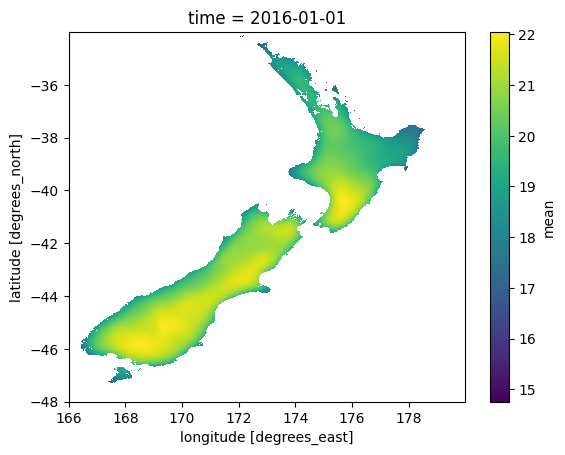

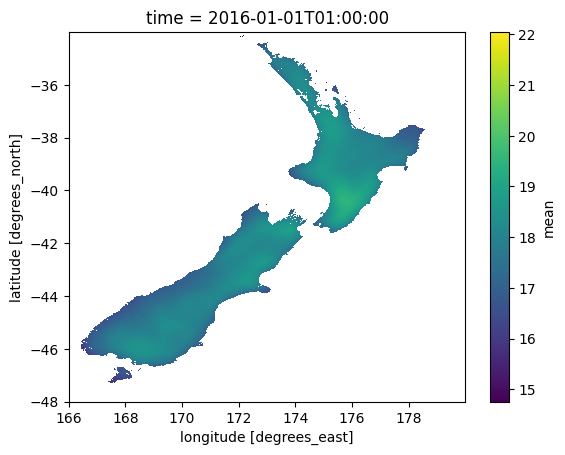

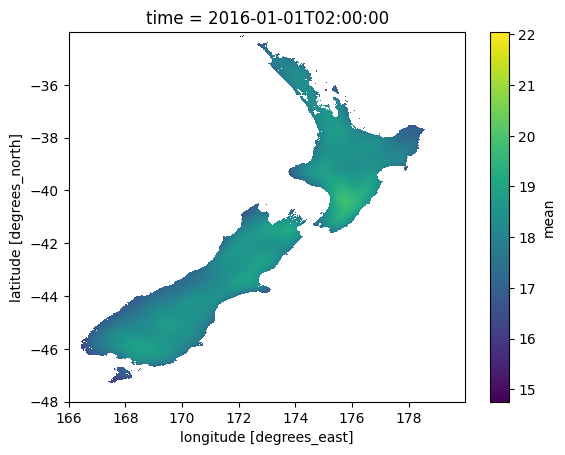

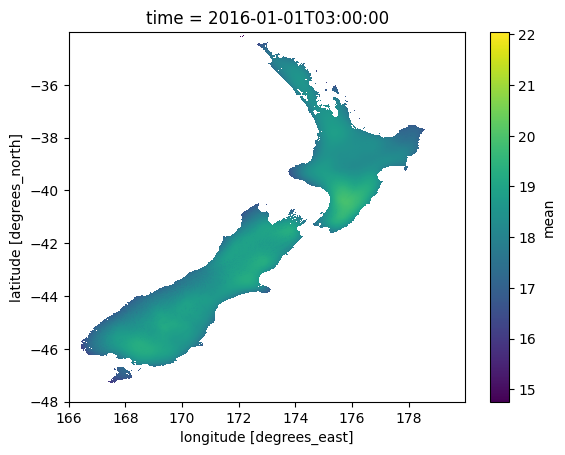

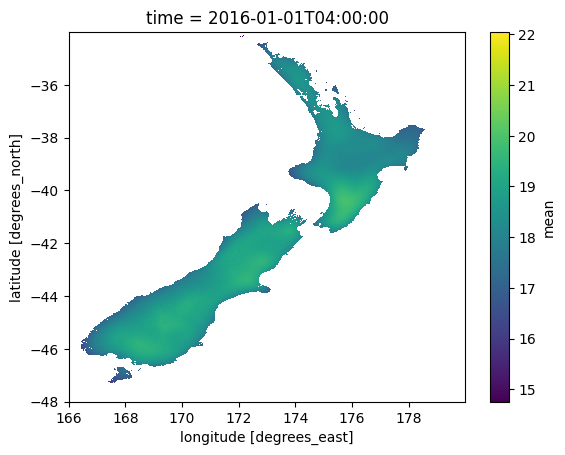

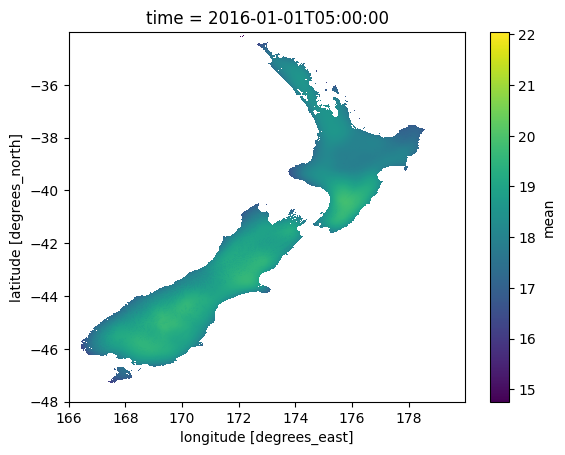

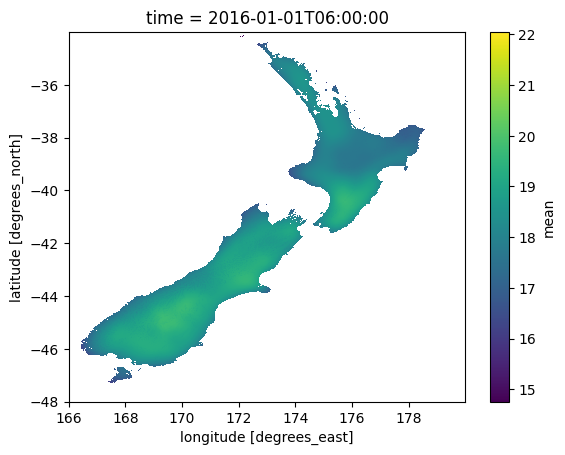

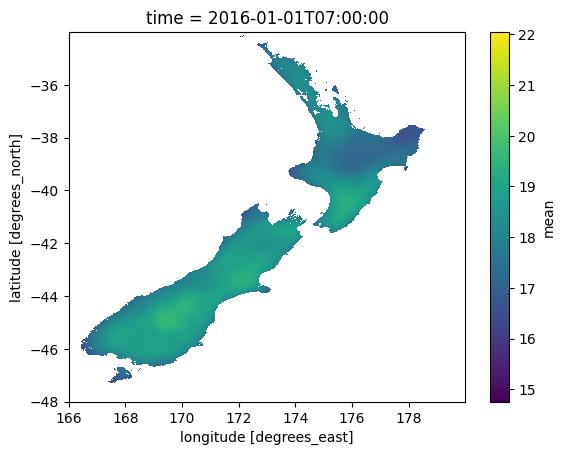

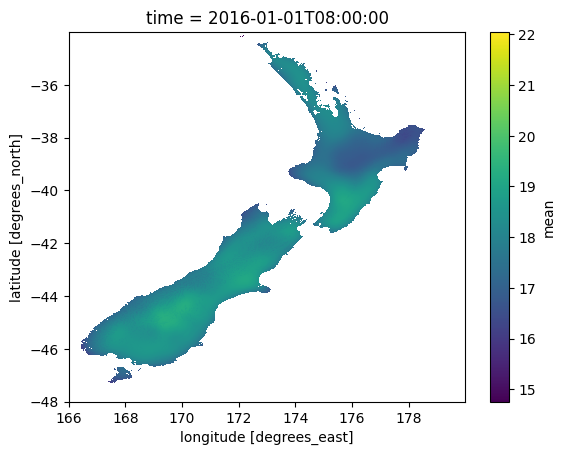

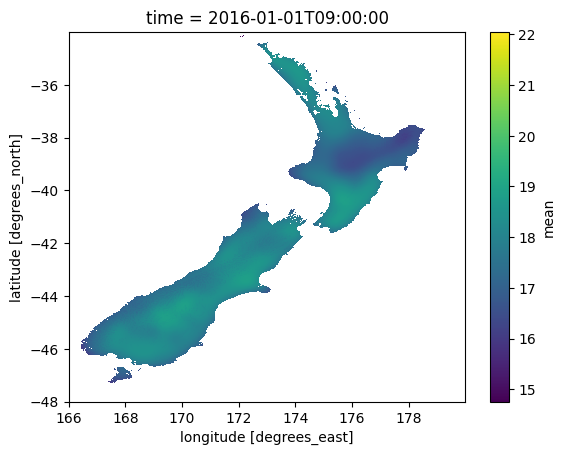

In [10]:
for i in range(10):
    fig, ax = plt.subplots()
    ds = pred[f'{var}_station']['mean']
    ds.isel(time=i).plot(ax=ax, 
                         vmax=ds.max(skipna=True), 
                         vmin=ds.min(skipna=True))

In [29]:
import xarray as xr

In [30]:
denorm_params = validate.data_processor.config[f'{var}_station']['params']
denorm_params

{'mean': 12.281831646182932, 'std': 5.548137253989303}

In [31]:
task = validate.task_loader(time)
task[0]['Y_c'][0][1]
# task_era5 = task[0]['Y_c'][0][0]
# task_era5

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [15]:
# task = validate.task_loader(time)
# task_era5 = task[0]['Y_c'][0][0]
# task_era5
# # if var != 'precipitation':
# #     denorm_params = validate.data_processor.config[f'{var}_station']['params']
# #     task_era5 = (task_era5 * denorm_params['std']) + denorm_params['mean']
# # else:
# #     denorm_params = validate.data_processor.config[f'{var}_station']['params']
# # era5_ds = ds.copy()
# era5_ds = xr.DataArray(task_era5 - 273.15)
# era5_ds.plot()
# ax = plt.gca()
# ax.set_ylim(ax.get_ylim()[::-1]) 

Removed stations

In [32]:
stations_to_validate = validate.load_stations(time, keep_stations=remove_stations_list)

Loading stations:   0%|          | 0/444 [00:00<?, ?it/s]

Loading stations: 100%|██████████| 444/444 [01:17<00:00,  5.74it/s]

158 stations with data at prediction time(s)
Keeping TAUPO AWS
Keeping CHRISTCHURCH AERO
Keeping MT COOK EWS
Keeping AUCKLAND AERO
Keeping ALEXANDRA AWS
Keeping TOLAGA BAY WXT AWS
Keeping WELLINGTON AERO
Keeping BLENHEIM AERO
Keeping DUNEDIN AERO AWS
Kept 9 stations


In [33]:
from nzdownscale.dataprocess.config import STATION_LATLON
for station in remove_stations_list:
    print(station, STATION_LATLON[station])
    

TAUPO AWS {'station_no': '1858', 'latitude': -38.74263, 'longitude': 176.08104, 'elevation': 400.0}
CHRISTCHURCH AERO {'station_no': '4843', 'latitude': -43.493, 'longitude': 172.537, 'elevation': 37.0}
MT COOK EWS {'station_no': '18125', 'latitude': -43.736000000000004, 'longitude': 170.09599999999998, 'elevation': 730.0}
AUCKLAND AERO {'station_no': '1962', 'latitude': -37.00813, 'longitude': 174.78873000000002, 'elevation': 7.0}
ALEXANDRA AWS {'station_no': '41163', 'latitude': -45.21452, 'longitude': 169.37548999999999, 'elevation': 230.0}
TOLAGA BAY WXT AWS {'station_no': '37836', 'latitude': -38.382, 'longitude': 178.308, 'elevation': 12.0}
WELLINGTON AERO {'station_no': '3445', 'latitude': -41.321999999999996, 'longitude': 174.804, 'elevation': 4.0}
BLENHEIM AERO {'station_no': '4322', 'latitude': -41.52, 'longitude': 173.872, 'elevation': 40.0}
DUNEDIN AERO AWS {'station_no': '7339', 'latitude': -45.92675, 'longitude': 170.19683999999998, 'elevation': 1.0}


In [34]:
station_dict = {}
for station in remove_stations_list:
    station_dict[station] = {**STATION_LATLON[station]}
    station_lat = station_dict[station]['latitude']
    station_lon = station_dict[station]['longitude']

    if station_lat in stations_to_validate.index.get_level_values('latitude'):
        station_values = stations_to_validate.xs(station_lat, level='latitude')
        station_values = station_values.xs(station_lon, level='longitude')
        station_dict[station]['values'] = station_values
        print(station)
        # print(station_values)
    else:
        print(f'{station} not in stations_to_validate')
        del station_dict[station]

TAUPO AWS not in stations_to_validate
CHRISTCHURCH AERO
MT COOK EWS
AUCKLAND AERO
ALEXANDRA AWS
TOLAGA BAY WXT AWS
WELLINGTON AERO
BLENHEIM AERO
DUNEDIN AERO AWS


In [35]:
import numpy as np
from tqdm import tqdm
from scipy.interpolate import griddata

# # pred_coarse = ds.coarsen(latitude=5, longitude=5, boundary="trim").mean()
era5_var = 't2m'
era5_interp = validate.era5_ds_raw[era5_var].interp(
    coords={
        "latitude": ds["latitude"],
        "longitude": ds["longitude"],
    },
    method="nearest",
)
topo = validate.data_processor_dict["highres_aux_ds"]["elevation"]
topo_unnorm = validate.data_processor.unnormalise(topo)
interpolated_topo = topo_unnorm.interp_like(ds)
land_sea_mask = ~(interpolated_topo == 0)
missing_land_values = xr.where(
    land_sea_mask & np.isnan(era5_interp), True, False
)
print("Missing land values calculated")

era5_interp_filled = era5_interp.copy()
# era5_var = validate.get_variable_name('era5')
for t in tqdm(time, desc="Filling missing values"):
    era5_da = era5_interp.sel(time=t)
    valid_points = np.array(np.nonzero(~np.isnan(era5_da))).T
    valid_values = era5_da.values[~np.isnan(era5_da)]
    missing_land_values_da = missing_land_values.sel(time=t)
    invalid_points = np.array(np.nonzero(missing_land_values_da)).T
    # Perform nearest neighbor interpolation
    interpolated_values = griddata(
        valid_points, valid_values, invalid_points, method="nearest"
    )
    # Fill the era5_interp DataArray with the interpolated values
    era5_interp_filled.sel(time=t).values[tuple(invalid_points.T)] = (
        interpolated_values
    )

Missing land values calculated


Filling missing values: 100%|██████████| 745/745 [01:11<00:00, 10.44it/s]


In [68]:
coarse_res_topo = 

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 191, time: 744)
Coordinates:
  * longitude  (longitude) float32 161.0 161.1 161.2 161.3 ... 182.8 182.9 183.0
  * latitude   (latitude) float32 -31.0 -31.1 -31.2 -31.3 ... -49.8 -49.9 -50.0
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-01-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-10 20:37:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [78]:
lowres_topo = validate.data_processor_dict['aux_ds']['elevation']
lowres_topo = validate.data_processor.unnormalise(lowres_topo)

In [87]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

CHRISTCHURCH AERO
Low res: 28.6004638671875, high res: 37.0
MT COOK EWS
Low res: 1606.56103515625, high res: 730.0
AUCKLAND AERO
Low res: 0.6156005859375, high res: 7.0
ALEXANDRA AWS
Low res: 231.51806640625, high res: 230.0
TOLAGA BAY WXT AWS
Low res: 15.522705078125, high res: 12.0
WELLINGTON AERO
Low res: 36.7293701171875, high res: 4.0
BLENHEIM AERO
Low res: 99.32281494140625, high res: 40.0
DUNEDIN AERO AWS
Low res: 32.027587890625, high res: 1.0


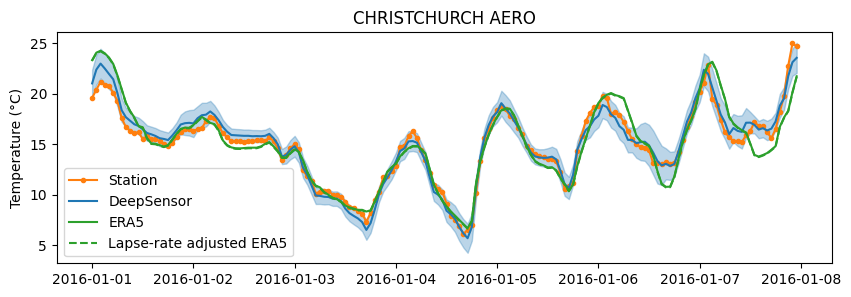

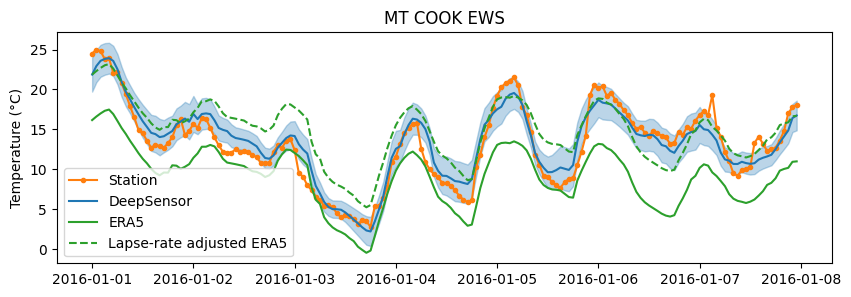

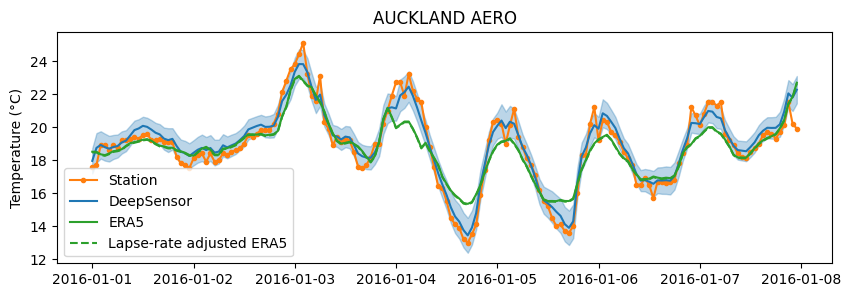

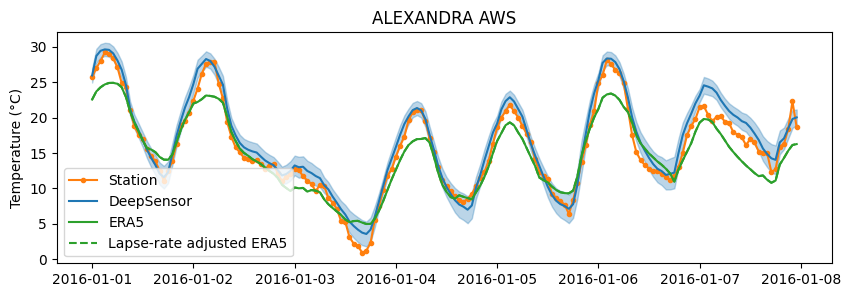

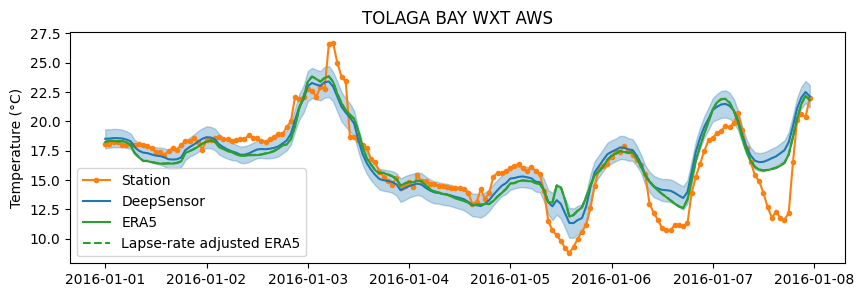

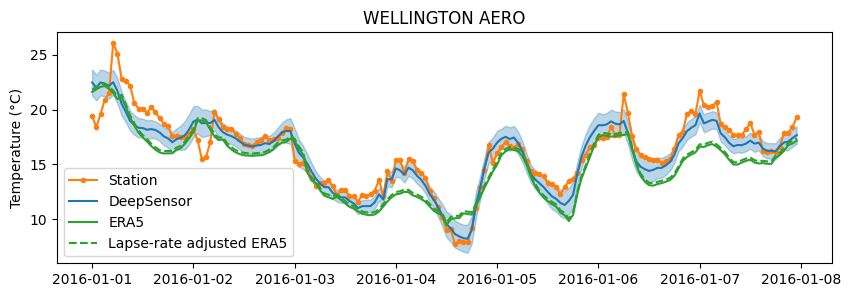

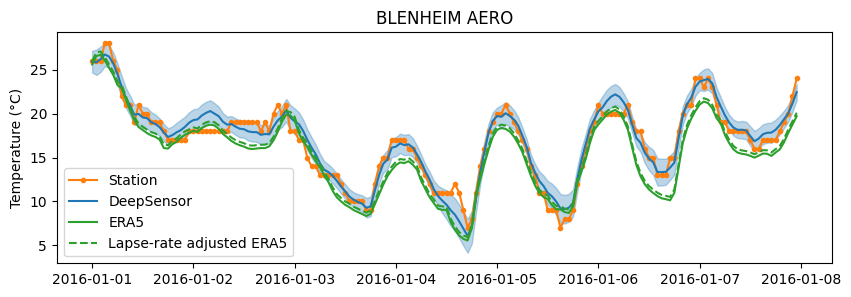

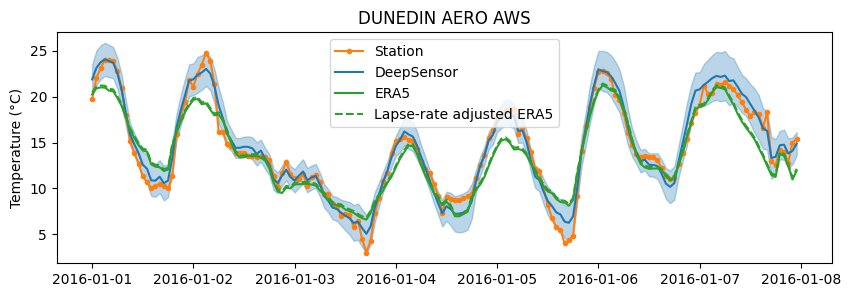

In [105]:
for station, dict_values in station_dict.items():
    fig, ax = plt.subplots(figsize=(10, 3))
    # remove duplicates
    timeseries = dict_values['values'].reset_index().drop_duplicates(subset='time').set_index('time')

    first_day = 0
    last_day = 7
    times_to_plot = pred_values.time.values[(24 * first_day):(24 * last_day)]
    # times_to_plot = pred_values.time.values

    # DeepSensor
    pred_values = pred[f'{var}_station'].sel({'latitude': dict_values['latitude'], 
            'longitude': dict_values['longitude']},
            method='nearest')

    timeseries['deepsensor'] = pred_values['mean']
    timeseries['deepsensor_std'] = pred_values['std']

    # ERA5 
    era5 = era5_interp_filled.sel({'latitude': dict_values['latitude'], 
                                'longitude': dict_values['longitude']},
                                method='nearest')
    elevation = dict_values['elevation']
    
    if var == 'temperature':
        low_res_topo_at_location = float(lowres_topo.sel({'latitude': dict_values['latitude'],
                                                    'longitude': dict_values['longitude']},
                                                    method='nearest').values)
        print(f'{station}')
        print(f'Low res: {low_res_topo_at_location}, high res: {elevation}')
        # Adjust by lapse rate of 6K / 1000m
        lapse_rate = 0.0065 * (elevation - low_res_topo_at_location)
        lapse_era5 = era5 - lapse_rate
        timeseries['era5_lapse'] = lapse_era5 - 273.15 
        timeseries['era5'] = era5 - 273.15

    else:
        timeseries['era5'] = era5

    ax.plot(timeseries[f'{var}_station'].loc[times_to_plot], label='Station',
             color=colors[1], marker='o', markersize=3)
    ax.plot(timeseries['deepsensor'].loc[times_to_plot], label='DeepSensor', color=colors[0])
    ax.fill_between(times_to_plot, (timeseries['deepsensor'] - timeseries['deepsensor_std']).loc[times_to_plot], 
                    (timeseries['deepsensor'] + timeseries['deepsensor_std']).loc[times_to_plot], 
                    color=colors[0], alpha=0.3)
    ax.plot(timeseries['era5'].loc[times_to_plot], label='ERA5', color=colors[2], )
    if var == 'temperature':
        ax.plot(timeseries['era5_lapse'].loc[times_to_plot], label=f'Lapse-rate adjusted ERA5',
            color=colors[2], linestyle='--')

    units = '°C' if var == 'temperature' else 'mm/hr'
    ax.set_ylabel(f'{var.capitalize()} ({units})')
    ax.legend()
    ax.set_title(station)

    # fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/temp_timeseries/{station}_2016_wk1.pdf')
    

In [52]:
timeseries['deepsensor']

time
2016-01-01 00:00:00    21.878298
2016-01-01 01:00:00    23.128368
2016-01-01 02:00:00    23.743462
2016-01-01 03:00:00    24.066154
2016-01-01 04:00:00    23.888630
                         ...    
2016-01-31 20:00:00    14.164098
2016-01-31 21:00:00    16.943228
2016-01-31 22:00:00    19.652002
2016-01-31 23:00:00    21.615669
2016-02-01 00:00:00    22.976147
Name: deepsensor, Length: 745, dtype: float32

In [47]:
timeseries['deepsensor'] - timeseries['deepsensor_std']

time
2016-01-01 00:00:00    20.271473
2016-01-01 01:00:00    21.230268
2016-01-01 02:00:00    21.890879
2016-01-01 03:00:00    22.256609
2016-01-01 04:00:00    22.126549
                         ...    
2016-01-31 20:00:00    12.606146
2016-01-31 21:00:00    15.258149
2016-01-31 22:00:00    17.909119
2016-01-31 23:00:00    19.892958
2016-02-01 00:00:00    21.331882
Length: 745, dtype: float32

# Model outputs

In [111]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [119]:
min_val = pred['temperature_station']['mean'].isel(time=0).min()
max_val = pred['temperature_station']['mean'].isel(time=0).max()

In [184]:
plt.rcParams.update({
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 12,     # Axis label font size
    'xtick.labelsize': 12,    # X-axis tick label font size
    'ytick.labelsize': 10,    # Y-axis tick label font size
    # 'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 18    # Figure title font size
})

In [219]:
era5_t0.time

<xarray.DataArray 'time' ()>
array('2016-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-01-01
Attributes:
    long_name:  time

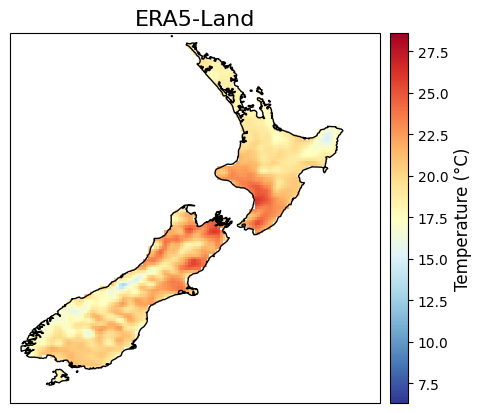

In [194]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))
cbar_kwargs = {'label': 'Temperature (°C)', 
               'pad': 0.02}

era5_t0 = validate.era5_ds_raw[era5_var].isel(time=0)
# era5_t0 = era5_interp_filled.isel({'time':0})
era5_t0_c = era5_t0 - 273.15
era5_t0_c.plot(cmap='RdYlBu_r', ax=ax, vmin=min_val, vmax=max_val,
                cbar_kwargs=cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ERA5-Land')

fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/era5_land_temp.png',
            bbox_inches='tight')

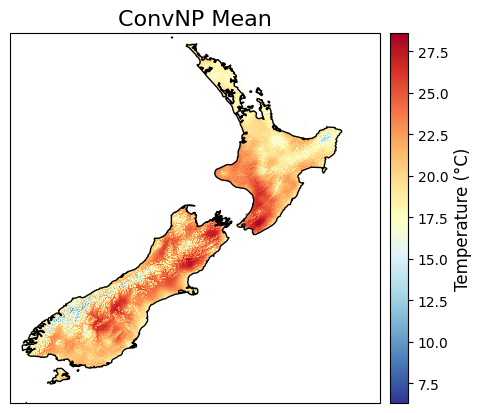

In [195]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

cbar_kwargs = {'label': 'Temperature (°C)',
               'pad': 0.02}

convnp_t0 = pred[f'{var}_station'].isel({'time':0})['mean']
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='RdYlBu_r', ax=ax, vmin=min_val, vmax=max_val,
               cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP Mean')
fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_temp.png',
            bbox_inches='tight')


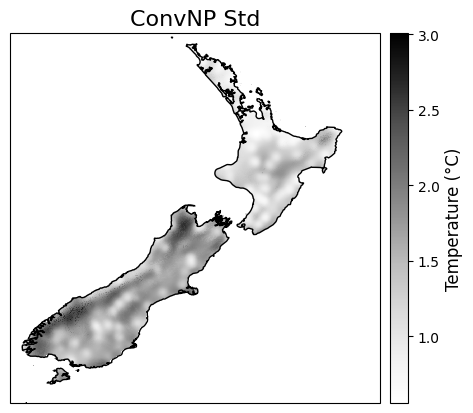

In [196]:
from matplotlib.patches import bbox_artist


fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))

cbar_kwargs = {'label': 'Temperature (°C)',
               'pad': 0.02}

convnp_t0 = pred[f'{var}_station'].isel({'time':0})['std']
# era5_t0_c = era5_t0 - 273.15
convnp_t0.plot(cmap='Greys', ax=ax, cbar_kwargs = cbar_kwargs)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('ConvNP Std')
fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/convnp_std.png',
            bbox_inches='tight')

In [197]:
stations_df = validate.load_stations(time)

Loading stations: 100%|██████████| 444/444 [01:20<00:00,  5.55it/s]

158 stations with data at prediction time(s)


In [199]:
convnp_list = []
era5_list = []

for _, row in tqdm(stations_df.iterrows(), total=stations_df.shape[0]):
    time, lat, lon = row.name  # Assuming the index contains these values
    convnp_value = pred[f'{var}_station'].sel({'latitude': lat, 'longitude': lon, 'time': time}, method='nearest')['mean'].values
    era5_value = era5_interp_filled.sel({'latitude': lat, 'longitude': lon, 'time': time}, method='nearest').values
    
    convnp_list.append(convnp_value)
    era5_list.append(era5_value)

# Add the new columns to the dataframe
stations_df['convnp'] = convnp_list
stations_df['era5'] = era5_list


  0%|          | 336/117710 [00:00<02:50, 687.71it/s]

100%|██████████| 117710/117710 [02:42<00:00, 726.18it/s]


In [206]:
convnp_diffs

array([ 1.1326011 ,  0.1691986 , -0.6290352 , ..., -0.3075722 ,
       -0.23906937, -0.4199211 ], dtype=float32)

In [207]:
stations_df

temperature_station     convnp       era5
time       latitude  longitude                                           
2016-01-01 -46.58700 168.37600                 19.1  20.232601  294.28983
           -46.44900 169.81000                 17.4  17.569199  291.78427
           -46.41727 168.33045                 21.2  20.570965  294.04178
           -46.41104 168.31779                 21.0   20.52557  294.04178
           -46.29282 169.73150                 18.8   20.12542  292.61996
...                                             ...        ...        ...
2016-02-01 -35.26200 173.91100                 22.7  23.118195  295.39236
           -35.13352 173.26294                 24.5   24.87285  297.06055
           -35.12900 174.01500                 22.8  22.492428  295.73456
           -35.06770 173.28740                 24.9   24.66093  297.06055
           -34.42963 172.68186                 23.2  22.780079    295.551

[117710 rows x 3 columns]

Text(0.5, 1.0, 'Temperature errors to stations')

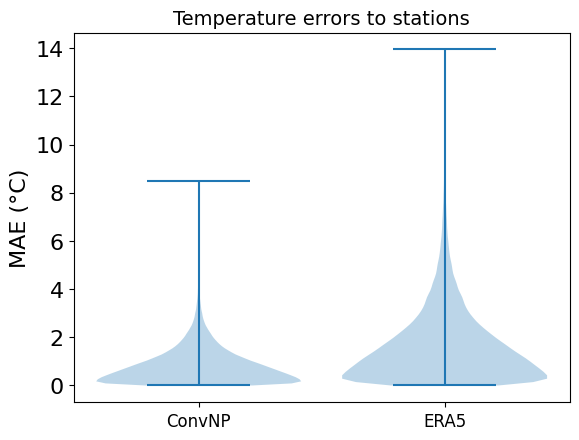

In [212]:
fig, ax = plt.subplots()

era5_diffs = stations_df['era5'] - stations_df[f'{var}_station'] - 273.15
convnp_diffs = stations_df['convnp'] - stations_df[f'{var}_station']

convnp_diffs= np.array(convnp_diffs.values, dtype=np.float32)
era5_diffs = np.array(era5_diffs.values, dtype=np.float32)

# remove nans
convnp_diffs = convnp_diffs[~np.isnan(convnp_diffs)]
era5_diffs = era5_diffs[~np.isnan(era5_diffs)]

positions = [1, 1.6]
ax.violinplot(dataset=[abs(convnp_diffs), 
                       abs(era5_diffs)], positions=positions)
ax.tick_params(axis="y", labelsize=16)
ax.set_xticks(positions, labels=["ConvNP", "ERA5"], fontsize=12)
ax.set_ylabel("MAE (°C)", fontsize=16)
ax.set_title("Temperature errors to stations", fontsize=14)


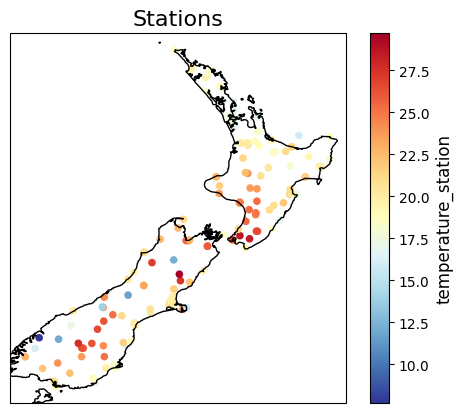

In [218]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))
the_time = pred['temperature_station'].time.values[0]
# cbar_kwargs = {'label': 'Temperature (°C)',
#                'pad': 0.02}
stations_t0 = stations_df[stations_df.index.get_level_values('time') == the_time]
stations_t0 = stations_t0.reset_index()
stations_t0.plot.scatter(x='longitude', y='latitude', c='temperature_station', cmap='RdYlBu_r', ax=ax,) #vmin=0, vmax=max_val,)
ax.add_feature(cf.BORDERS)
ax.coastlines()
ax.set_title('Stations')
# fig.savefig(f'/home/emily/deepsensor/deepweather-downscaling/experiments/deepsensor/emily_dev_local/paper/images/example_outputs/stations_temp.png',
#             bbox_inches='tight')

Mountain top temperature

In [ ]:
mtn_temp_filepath = '/mnt/temp/projects/DeepWeather/data_delete/NIWA_MountainTemperature_Data_20240415/MountainTemperatureSensorData_20240415.csv'
mtn_temp_metadata_filepath = '/mnt/temp/projects/DeepWeather/data_delete/NIWA_MountainTemperature_Data_20240415/MountainTemperatureSensorMetaData_20240415.csv'

mtn_temp = pd.read_csv(mtn_temp_filepath)
mtn_temp_metadata = pd.read_csv(mtn_temp_metadata_filepath)

In [ ]:
sitename = 'Mt_Hutt_01'
site_data = mtn_temp[mtn_temp['SiteName'] == sitename]
site_data

,DateTime,Value,SiteName
0,2021-09-19 00:00+1200,-1.097,Mt_Hutt_01
10,2021-09-19 00:00+1200,-0.668,Mt_Hutt_01
20,2021-09-19 01:00+1200,-0.367,Mt_Hutt_01
30,2021-09-19 01:00+1200,0.019,Mt_Hutt_01
40,2021-09-19 02:00+1200,-0.239,Mt_Hutt_01
...,...,...,...
1154052,2023-10-20 09:00+1200,8.920,Mt_Hutt_01
1154060,2023-10-20 09:00+1200,9.310,Mt_Hutt_01
1154098,2023-10-20 10:00+1200,8.450,Mt_Hutt_01
1154106,2023-10-20 10:00+1200,6.990,Mt_Hutt_01


In [ ]:
site_metadata = mtn_temp_metadata[mtn_temp_metadata['SiteName'] == sitename]
site_lat = site_metadata['Latitude'].values[0]
site_lon = site_metadata['Longitude'].values[0]
site_elevation = site_metadata['Elevation'].values[0]

<Axes: title={'center': 'Mt_Hutt_01'}, xlabel='DateTime'>

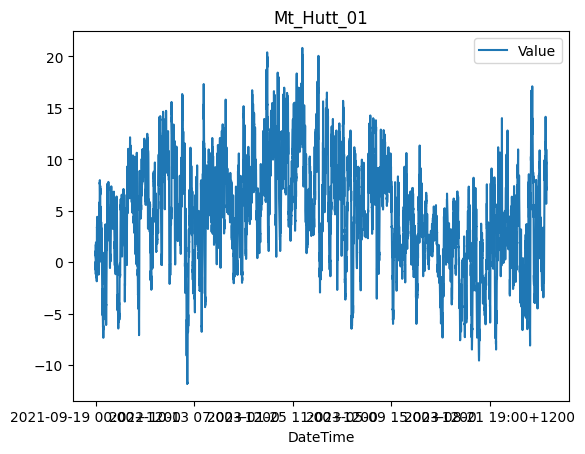

In [ ]:
site_data.plot(x='DateTime', y='Value', title=sitename)